# Compute Theoretical Asymptotic variance and velocity of Limiting Diffusion

In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
import scipy.linalg as scipy_linalg

$$\mathcal{L}^G \phi(\Theta) = \frac{\kappa}{2} \times [-\Theta \, \phi' + \phi^{''}]
\, + \,
\frac{1}{\sigma} \, [ \phi' + \Theta_+ \, ( \phi(-\Theta) - \phi(\Theta) ) )$$
We would like to solve the Poisson equation
$$\mathcal{L}^G \phi = F$$

Discretization of the diffusion term $\mu \, dt + \sigma \, dW$. One needs to find $(a,b,c)$ such that
$$a+b+c=1, \qquad \Delta \, (c-a) = \mu \, dt, \qquad (a+c)\Delta^2 - (\mu \, dt)^2 = \sigma^2 \, dt$$

In [2]:
def discretize_diffusion(mu,sqrt_vol,delta,dt):
    """
    discretize mu*dt + sqrt_vol*sqrt(dt)*dW
    parameter "delta" is the space discretization
    output: (a,b,c) = proba(-delta), proba(stay still), proba(+delta)
    """
    return np.linalg.solve(np.array([[1.,1.,1.],[-delta,0,delta],[delta**2,0,delta**2]]),
                           np.array([1,mu*dt,sqrt_vol**2*dt + (mu*dt)**2]) )

def Build_Markov_Transition(L, delta, dt, kappa, sigma):
    """
    Compute the discretization of the limiting diffusion in the DBPS paper
    
    args:
    ====
     L: discreize in between -L and L
     delta: space discretization
     dt: space discretization
     kappa / sigma: generator parameter
     
    out:
    ===
     states: state space
     P: Markov kernel
     dim: size of the state space
    """
    states = np.arange(-L,L+delta,delta)
    dim = len(states)
    P = np.zeros((dim,dim))

    #discretize P[0,:]
    mu = -0.5*kappa*states[0]+1/sigma
    sqrt_vol = np.sqrt(kappa)
    a,b,c = discretize_diffusion(mu,sqrt_vol,delta,dt)
    P[0,0]=a+b
    P[0,1] = c

    #discretize P[dim-1,:]
    k = dim-1
    proba_jump = dt*max(states[k],0)/sigma
    mu = -0.5*kappa*states[k]+1/sigma
    sqrt_vol = np.sqrt(kappa)
    a,b,c = discretize_diffusion(mu,sqrt_vol,delta,dt)
    if min(a,b,c) < 0:
        print(a,b,c)
        print("ERROR")
    P[k,k-1]=a*(1-proba_jump)
    P[k,k]=b*(1-proba_jump) + c*(1-proba_jump)
    index_minus = dim//2 - (k - dim//2)
    P[k,index_minus] =  P[k,index_minus] + proba_jump

    for k in np.arange(1,dim-1):
        proba_jump = dt*max(states[k],0)/sigma
        mu = -0.5*kappa*states[k]+1/sigma
        sqrt_vol = np.sqrt(kappa)
        a,b,c = discretize_diffusion(mu,sqrt_vol,delta,dt)
        if min(a,b,c) < 0:
            print("ERROR")
        P[k,k-1]=a*(1-proba_jump)
        P[k,k]=b*(1-proba_jump)
        P[k,k+1]=c*(1-proba_jump)
        index_minus = dim//2 - (k - dim//2)
        P[k,index_minus] =  P[k,index_minus] + proba_jump
    return states, P, dim

def Build_Markov_Kengo_Transition(L, delta, dt, kappa, sigma):
    """
    Compute the discretization of the limiting diffusion in Kengo's paper
    
    args:
    ====
     L: discreize in between -L and L
     delta: space discretization
     dt: space discretization
     kappa / sigma: generator parameter
     
    out:
    ===
     states: state space
     P: Markov kernel
     dim: size of the state space
    """
    states = np.arange(-L,L+delta,delta)
    invar = np.exp(-states**2/2.)
    invar = invar / np.sum(invar)
    dim = len(states)
    P = np.zeros((dim,dim))

    #discretize P[0,:]
    mu = 1. / sigma
    sqrt_vol = 0
    a,b,c = (0,1-mu*dt/delta,mu*dt/delta)
    proba_jump = 0
    proba_refresh = kappa*dt
    P[0,:] += proba_refresh*invar
    P[0,0] += (1.-proba_refresh-proba_jump)*(a+b)
    P[0,1] += (1.-proba_refresh-proba_jump)*c

    #discretize P[dim-1,:]
    k = dim-1
    proba_jump = dt*max(states[k],0)/sigma
    proba_refresh = kappa*dt
    mu = 1./sigma
    sqrt_vol = 0
    a,b,c = a,b,c = (0,1-mu*dt/delta,mu*dt/delta)
    if min(a,b,c) < 0:
        print(a,b,c)
        print("ERROR")
    P[k,:] += proba_refresh*invar
    P[k,k-1] += (1.-proba_refresh-proba_jump)*a
    P[k,k] += (1.-proba_refresh-proba_jump)*(b+c)
    index_minus = dim//2 - (k - dim//2)
    P[k,index_minus] += proba_jump

    for k in np.arange(1,dim-1):
        proba_jump = dt*max(states[k],0)/sigma
        proba_refresh = kappa*dt
        mu = 1./sigma
        sqrt_vol = 0
        a,b,c = a,b,c = (0,1-mu*dt/delta,mu*dt/delta)
        if min(a,b,c) < 0:
            print(a,b,c)
            print("ERROR")
        P[k,:] += proba_refresh*invar
        P[k,k-1] += (1.-proba_refresh-proba_jump)*a
        P[k,k] += (1.-proba_refresh-proba_jump)*b
        P[k,k+1] += (1.-proba_refresh-proba_jump)*c        
        index_minus = dim//2 - (k - dim//2)
        P[k,index_minus] += proba_jump
    return states, P, dim

def Build_Markov_OU_Transition(L, delta, dt, kappa, sigma):
    """
    Compute the discretization of a OU process
    
    args:
    ====
     L: discreize in between -L and L
     delta: space discretization
     dt: space discretization
     kappa / sigma: generator parameter
     
    out:
    ===
     states: state space
     P: Markov kernel
     dim: size of the state space
    """
    states = np.arange(-L,L+delta,delta)
    dim = len(states)
    P = np.zeros((dim,dim))

    #discretize P[0,:]
    mu = -0.5*kappa*states[0]
    sqrt_vol = np.sqrt(kappa)
    a,b,c = discretize_diffusion(mu,sqrt_vol,delta,dt)
    P[0,0]=a+b
    P[0,1] = c

    #discretize P[dim-1,:]
    k = dim-1
    proba_jump = 0
    mu = -0.5*kappa*states[k]
    sqrt_vol = np.sqrt(kappa)
    a,b,c = discretize_diffusion(mu,sqrt_vol,delta,dt)
    if min(a,b,c) < 0:
        print("ERROR")
    P[k,k-1]=a*(1-proba_jump)
    P[k,k]=b*(1-proba_jump) + c*(1-proba_jump)
    index_minus = dim//2 - (k - dim//2)
    P[k,index_minus] =  P[k,index_minus] + proba_jump

    for k in np.arange(1,dim-1):
        proba_jump = 0
        mu = -0.5*kappa*states[k]
        sqrt_vol = np.sqrt(kappa)
        a,b,c = discretize_diffusion(mu,sqrt_vol,delta,dt)
        if min(a,b,c) < 0:
            print("ERROR")
        P[k,k-1]=a*(1-proba_jump)
        P[k,k]=b*(1-proba_jump)
        P[k,k+1]=c*(1-proba_jump)
        index_minus = dim//2 - (k - dim//2)
        P[k,index_minus] =  P[k,index_minus] + proba_jump
    return states, P, dim


def compute_invariant_proba(P):
    """ given the Markov transition kernel P -- computes the invariant distribution """
    e,v = np.linalg.eig(P.T)
    index_invar = np.flip(np.argsort(np.real(e)), axis=0)[0]
    proba_invar = np.abs( v[:,index_invar] )
    proba_invar = proba_invar / np.sum(proba_invar)
    return proba_invar

def compute_poisson_solution(states, P, dt, dim, proba_invar):
    """
    Compute the solution of the Poisson Equation
    
    L(h) = states
    
    where L= (P - np.eye(dim))/dt
    
    args:
    ====
     L: discreize in between -L and L
     delta: space discretization
     dt: space discretization
     kappa / sigma: generator parameter
     
    out:
    ===
     states: state space
     P: Markov kernel
     dim: size of the state space
    """
    
    y_centred = states - np.sum(states*proba_invar)
    L = (P - np.eye(dim))/dt

    eps=10**-4
    poisson_solution = scipy_linalg.solve(L.T @ L + eps*np.eye(dim), L.T @ y_centred, sym_pos=True)
    poisson_solution = poisson_solution - np.sum(proba_invar * poisson_solution)
    return poisson_solution

def compute_asymptotic_variance(proba_invar, states, poisson_solution):
    return -2 * np.sum(proba_invar * states * poisson_solution)

In [3]:
L = 6
delta = 0.02
dt = 0.005*delta**2
kappa=1.
sigma=1.

mean:-7.384601742654873e-06 and variance:0.9999864558259675


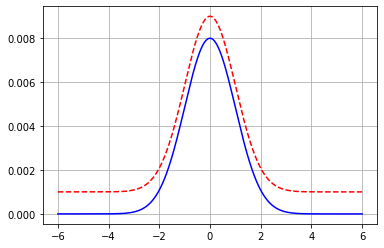

In [4]:
#SANITY CHECK
if True:
    #states, P, dim = Build_Markov_Kengo_Transtion(L, delta, dt, kappa, sigma)
    states, P, dim = Build_Markov_Transition(L, delta, dt, kappa, sigma)
    invar_proba = compute_invariant_proba(P)
    plt.plot(states, invar_proba, "b-")
    plt.plot(states, 0.001 + delta * np.exp(-states**2 / 2.) / np.sqrt(2*np.pi), "r--")
    plt.grid(True)
    mean, variance = np.sum(states * invar_proba), np.sum(states**2 * invar_proba)
    print('mean:{} and variance:{}'.format(mean,variance))

In [5]:
kappa_list = np.arange(0.1,10,0.3)
asymp_var_list_kengo = []
asymp_var_list_brownian = []

for kappa in kappa_list:
    #KENGO
    states, P, dim = Build_Markov_Kengo_Transition(L, delta, dt, kappa, sigma)    
    proba_invar = compute_invariant_proba(P)
    print("KENGO kappa = {:4.1f} \t mean = {:4.2f}  \t variance = {:4.2f}".format(kappa, np.sum(proba_invar*states),np.sum(proba_invar*states**2)))
    poisson_solution = compute_poisson_solution(states, P, dt, dim, proba_invar)
    asymp_var = compute_asymptotic_variance(proba_invar, states, poisson_solution)
    asymp_var_list_kengo += [asymp_var]
    
    #BROWNIAN
    states, P, dim = Build_Markov_Transition(L, delta, dt, kappa, sigma)    
    proba_invar = compute_invariant_proba(P)
    print("BROWN kappa = {:4.1f} \t mean = {:4.2f}  \t variance = {:4.2f}".format(kappa, np.sum(proba_invar*states),np.sum(proba_invar*states**2)))
    poisson_solution = compute_poisson_solution(states, P, dt, dim, proba_invar)
    asymp_var = compute_asymptotic_variance(proba_invar, states, poisson_solution)
    asymp_var_list_brownian += [asymp_var]

    

KENGO kappa =  0.1 	 mean = -0.01  	 variance = 1.02
BROWN kappa =  0.1 	 mean = -0.00  	 variance = 1.00
KENGO kappa =  0.4 	 mean = -0.01  	 variance = 1.01
BROWN kappa =  0.4 	 mean = -0.00  	 variance = 1.00
KENGO kappa =  0.7 	 mean = -0.01  	 variance = 1.01
BROWN kappa =  0.7 	 mean = -0.00  	 variance = 1.00
KENGO kappa =  1.0 	 mean = -0.00  	 variance = 1.01
BROWN kappa =  1.0 	 mean = -0.00  	 variance = 1.00
KENGO kappa =  1.3 	 mean = -0.00  	 variance = 1.01
BROWN kappa =  1.3 	 mean = -0.00  	 variance = 1.00
KENGO kappa =  1.6 	 mean = -0.00  	 variance = 1.01
BROWN kappa =  1.6 	 mean = -0.00  	 variance = 1.00
KENGO kappa =  1.9 	 mean = -0.00  	 variance = 1.01
BROWN kappa =  1.9 	 mean = -0.00  	 variance = 1.00
KENGO kappa =  2.2 	 mean = -0.00  	 variance = 1.01
BROWN kappa =  2.2 	 mean = -0.00  	 variance = 1.00
KENGO kappa =  2.5 	 mean = -0.00  	 variance = 1.01
BROWN kappa =  2.5 	 mean = -0.00  	 variance = 1.00
KENGO kappa =  2.8 	 mean = -0.00  	 variance 

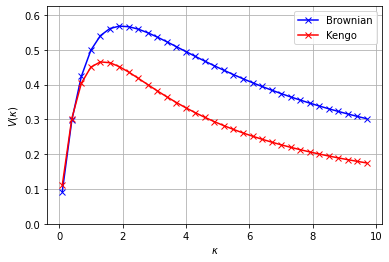

In [6]:
plt.plot(kappa_list,  asymp_var_list_brownian, "b-x", label="Brownian")
plt.plot(kappa_list,  asymp_var_list_kengo, "r-x", label="Kengo")
plt.legend()
#plt.plot(kappa_list,  kappa_list/4+0.1, "-x") #theory
plt.ylim(0, np.max(asymp_var_list_brownian)*1.1)
plt.xlabel(r"$\kappa$")
plt.ylabel("$V(\kappa)$")
plt.grid(True)


In [7]:
def dot_product(kappa, dt):
    x = -np.abs( np.random.normal(0,1) )
    t = 0
    while True:
        t += dt
        x += (1-0.5*kappa*x)*dt + np.sqrt(kappa*dt)*np.random.normal(0,1)
        if np.random.rand() < x*dt:
            return np.exp(-kappa*t/2)
        

n_samples = 10**4
dt = 0.05

dot_product_list = []
for kappa in kappa_list:
    dot_product_mean = np.mean( [dot_product(kappa, dt) for _ in range(n_samples)] )
    print("kappa: {0:2.2f} \t Dot Product: {1:2.2f}".format(kappa, dot_product_mean))
    dot_product_list.append(dot_product_mean)

kappa: 0.10 	 Dot Product: 0.90
kappa: 0.40 	 Dot Product: 0.67
kappa: 0.70 	 Dot Product: 0.51
kappa: 1.00 	 Dot Product: 0.40
kappa: 1.30 	 Dot Product: 0.33
kappa: 1.60 	 Dot Product: 0.28
kappa: 1.90 	 Dot Product: 0.23
kappa: 2.20 	 Dot Product: 0.21
kappa: 2.50 	 Dot Product: 0.18
kappa: 2.80 	 Dot Product: 0.16
kappa: 3.10 	 Dot Product: 0.15
kappa: 3.40 	 Dot Product: 0.14
kappa: 3.70 	 Dot Product: 0.13
kappa: 4.00 	 Dot Product: 0.12
kappa: 4.30 	 Dot Product: 0.11
kappa: 4.60 	 Dot Product: 0.10
kappa: 4.90 	 Dot Product: 0.10
kappa: 5.20 	 Dot Product: 0.09
kappa: 5.50 	 Dot Product: 0.08
kappa: 5.80 	 Dot Product: 0.08
kappa: 6.10 	 Dot Product: 0.08
kappa: 6.40 	 Dot Product: 0.07
kappa: 6.70 	 Dot Product: 0.07
kappa: 7.00 	 Dot Product: 0.07
kappa: 7.30 	 Dot Product: 0.07
kappa: 7.60 	 Dot Product: 0.06
kappa: 7.90 	 Dot Product: 0.06
kappa: 8.20 	 Dot Product: 0.06
kappa: 8.50 	 Dot Product: 0.06
kappa: 8.80 	 Dot Product: 0.06
kappa: 9.10 	 Dot Product: 0.05
kappa: 9

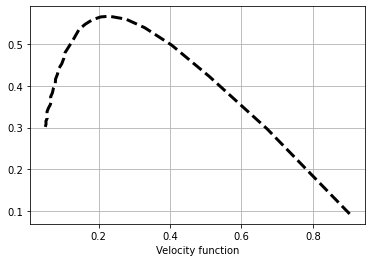

In [12]:
plt.plot(dot_product_list, asymp_var_list_brownian, "k--", linewidth=3)
plt.xlabel("Dot Product Statistics")
plt.xlabel("Velocity function")
plt.grid(True)

In [11]:
#save to disk
n_kappa = len(kappa_list)
asymp_var_array = np.zeros((n_kappa, 4))
asymp_var_array[:,0] = kappa_list
asymp_var_array[:,1] = dot_product_list
asymp_var_array[:,2] = asymp_var_list_brownian
asymp_var_array[:,3] = asymp_var_list_kengo
asymp_var_array.dump("./simulation_results/asympt_var.npy")
asymp_var_array = np.load("./simulation_results/asympt_var.npy", allow_pickle=True)